In [1]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


mask = np.load('mask_4th.npy')
mask = mask[np.newaxis,:,:]
mask = mask.repeat(365,axis=0)

folder_data_4th = "/Odyssey/private/t22picar/data/glorys_15m/"
file_glorys_4th = "glorys_15.81m_2019-01-01-2020-01-01_4th.nc"
maps_glo_4th = xr.open_dataset(folder_data_4th+file_glorys_4th)
maps_glo_4th = maps_glo_4th.rename({'lat': 'latitude'})
maps_glo_4th = maps_glo_4th.rename({'lon': 'longitude'})

time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = './results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
segment_lenght =  np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

In [2]:
def import_maps(maps):

    if maps == 'duacs':
        list_of_maps = sorted(glob('/Odyssey/private/t22picar/2023a_SSH_mapping_OSE/data/maps/DUACS_global_allsat-alg/*.nc'))
        ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
        ds_maps = ds_maps.drop("ugosa").drop("sla").drop("vgosa").drop("adt")

    if maps == "gc":
        list_of_maps = '/Odyssey/private/t22picar/data/uv/globcurrent_15.00m_2019-01-01-2020-01-01.nc'
        ds_maps = xr.open_dataset(list_of_maps)
        ds_maps = ds_maps.sel(depth=ds_maps.depth[0])

    if maps == "neurost":
        list_of_maps = sorted(glob('/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH_allsat-alg/NeurOST_SSH_allsat-alg_*_20240115.nc'))
        ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
        ds_maps = ds_maps.transpose('time','latitude','longitude')

    if maps == "neurostv2":
        #list_of_maps = sorted(glob('/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH-SST_allsat-alg/*.nc'))
        #ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
        #ds_maps = ds_maps.transpose('time','latitude','longitude')

        list_of_maps = '/Odyssey/private/t22picar/data/uv/NeurOST_SST-SSH_uv_allsat-al_2019_4th.nc'
        ds_maps = xr.open_dataset(list_of_maps)
        

    if maps == "glorys":
        list_of_maps = "/Odyssey/private/t22picar/data/glorys_15m/glorys_15.81m_2019-01-01-2020-01-01.nc"
        ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
        ds_maps = ds_maps.sel(depth=ds_maps.depth[0])

    if maps == "unetL4_w":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_wind_to_u_v_test_L4/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_w_neurost":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_neurost_sst_wind_to_u_v_test_L4_1y/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_w_4dvar":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_4dvar_sst_wind_to_u_v_test_L4_1y/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_w_mur":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_mur_w_to_u_v_L4_1y/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_10y":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_to_u_v_L4_10y/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_10y_11d":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_to_u_v_L4_10y_11d/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4_w_10y_11d":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_w_to_u_v_L4_10y_11d/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)

    if maps == "unetL4":
        result_filepath = "/Odyssey/private/t22picar/4dvarnet-uv/rec/multivar_mapping_ssh_sst_to_u_v_test_L4_1y/test_data.nc"
        ds_maps = xr.open_dataset(result_filepath)


    return ds_maps

def check_lon(ds_maps):

    if np.max(ds_maps.longitude.values) > 180:
        ds_maps.coords['longitude'] = (ds_maps.coords['longitude'] + 180) % 360 - 180
        ds_maps = ds_maps.sortby(ds_maps.longitude)
        
    return ds_maps


In [3]:
#filenames_drifters = sorted(glob('/work/ALT/swot/aval/wisa/data_challenge_ose/data/independent_drifters/uv_drifters_*.nc'))
filenames_drifters = sorted(glob('../../data/independent_drifters/uv_drifters_*.nc'))
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
ds_drifter

<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

In [4]:
# List of maps to evaluate

#list_maps = ['duacs','gc','neurost','unetL4_w',unetL4_neurost]
list_maps =  ['unetL4_w_10y_11d']

# Import the maps

for maps in list_maps: 

    stat_output_filename = f'{output_dir}/stat_uv_15m_{maps}.nc'   # output statistical analysis filename
    psd_output_filename = f'{output_dir}/psd_uv_15m_{maps}.nc'     # output spectral analysis filename

    ds_maps = import_maps(maps)
    #print(ds_map)
    ds_maps = ds_maps.sel(time=slice(time_min, time_max))

    if not "ugos" in list(ds_maps.variables.keys()):
        ds_maps = ds_maps.rename({'uo': 'ugos'})
        ds_maps = ds_maps.rename({'vo': 'vgos'})
        
    if not 'longitude' in list(ds_maps.coords.keys()):
        ds_maps = ds_maps.rename({'lat': 'latitude'})
        ds_maps = ds_maps.rename({'lon': 'longitude'})

# Check the lon

    ds_maps = check_lon(ds_maps)

# Check the grid and interpolation 4th

    ds_maps = ds_maps.interp({"latitude":maps_glo_4th.latitude, "longitude":maps_glo_4th.longitude}, method="linear")
    
# Add the mask

    ds_maps = ds_maps.where(mask, np.nan)

# Compute the stats and save

    ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
    ds_interp = ds_interp.dropna('time')
    ds_interp = ds_interp.sortby('time')
    ds_interp
    
    # Compute gridded stats
    compute_stat_scores_uv(ds_interp, stat_output_filename)
    compute_psd_scores_current(ds_interp, psd_output_filename, lenght_scale=segment_lenght)

2025-05-15 14:02:27 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-05-15 14:02:27 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-05-15 14:02:28 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-05-15 14:02:28 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2025-05-15 14:02:28 INFO     fet

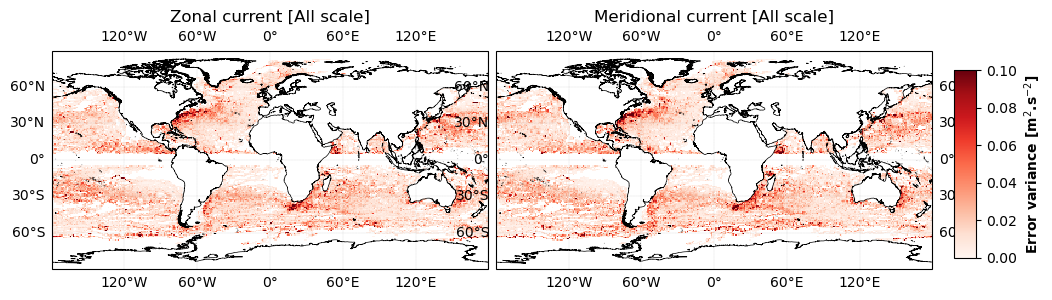

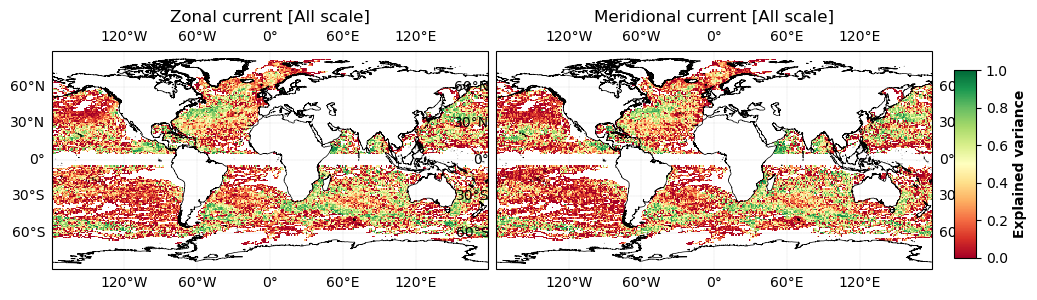

In [5]:
plot_stat_score_map_uv_png(stat_output_filename)

In [6]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.023728,0.021289,0.021803,0.051800,0.022967,0.045225,0.541925,0.529263
offshore_highvar,0.034326,0.035003,0.098282,0.139791,0.092024,0.121941,0.754450,0.712952
offshore_lowvar,0.019764,0.016922,0.015097,0.040414,0.012456,0.030033,0.510963,0.436562
equatorial_band,0.025962,0.024240,0.048947,0.091736,0.027563,0.058091,0.716986,0.582717
arctic,0.013735,0.014584,0.003528,0.018756,0.004287,0.019907,0.267691,0.267380
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


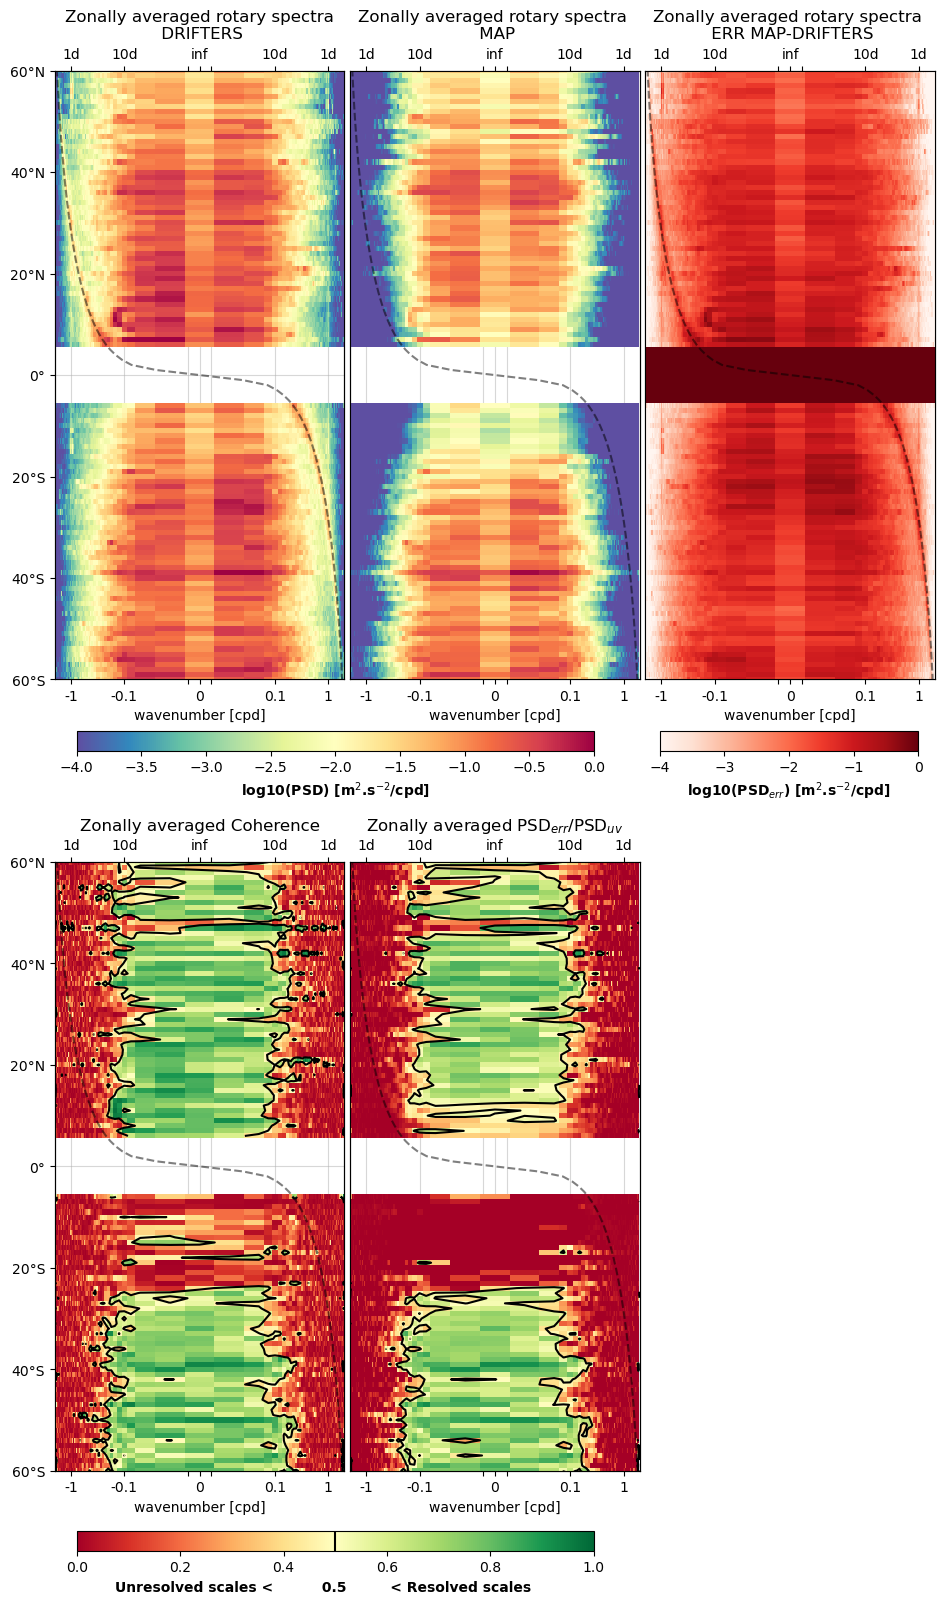

In [7]:
plot_psd_scores_currents_png(psd_output_filename)